In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.cluster import AgglomerativeClustering

In [2]:
df = pd.read_csv("../../data/preprocessed/base.csv")
df['periodo_dt'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')
df.shape

(2945818, 14)

# Clientes

#### Clientes que más compraron toneladas

In [141]:
# Volumen total por cliente
tn_por_cliente_menos = (
    df.groupby('customer_id')['tn']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Renombrar columna
tn_por_cliente_menos.columns = ['customer_id', 'total_toneladas']

# Calcular total global de toneladas
total_global = tn_por_cliente_menos['total_toneladas'].sum()

# Agregar porcentaje y acumulado
tn_por_cliente_menos['porcentaje_tn'] = (tn_por_cliente_menos['total_toneladas'] / total_global) * 100
tn_por_cliente_menos['porcentaje_acumulado'] = tn_por_cliente_menos['porcentaje_tn'].cumsum()

# Calcular cantidad de compras por cliente
cantidad_compras = df.groupby('customer_id').size().reset_index(name='cantidad_compras')

# Calcular cantidad de productos distintos por cliente
productos_distintos = df.groupby('customer_id')['product_id'].nunique().reset_index(name='productos_distintos')

# Unir todo
tn_por_cliente_menos = tn_por_cliente_menos.merge(cantidad_compras, on='customer_id', how='left')
tn_por_cliente_menos = tn_por_cliente_menos.merge(productos_distintos, on='customer_id', how='left')

# Mostrar
# display(tn_por_cliente_menos.sort_values(by='productos_distintos', ascending=False).head(13))
display(tn_por_cliente_menos.head(13))

,customer_id,total_toneladas,porcentaje_tn,porcentaje_acumulado,cantidad_compras,productos_distintos
0,10001,109203.60059,8.241852,8.241852,24914,1094
1,10002,77333.16887,5.836516,14.078368,23224,1006
2,10003,71375.91941,5.386908,19.465276,23927,1041
3,10004,63065.94269,4.759735,24.225011,24234,1033
4,10005,51467.04585,3.884339,28.109350,21189,806
5,10006,49779.23364,3.756956,31.866305,18077,810
6,10007,43740.39629,3.301190,35.167496,23257,1019
7,10008,41962.99046,3.167045,38.334541,9028,381
8,10009,38742.71591,2.924004,41.258545,16415,694
9,10011,34675.44337,2.617037,43.875582,17019,806


#### Clientes que menos compraron toneladas

In [70]:
# Volumen total por cliente
tn_por_cliente_menos = (
    df.groupby('customer_id')['tn']
    .sum()
    .sort_values(ascending=True)
    .reset_index()
)

# Renombrar columna
tn_por_cliente_menos.columns = ['customer_id', 'total_toneladas']

# Calcular total global de toneladas
total_global = tn_por_cliente_menos['total_toneladas'].sum()

# Agregar porcentaje y acumulado
tn_por_cliente_menos['porcentaje_tn'] = (tn_por_cliente_menos['total_toneladas'] / total_global) * 100
tn_por_cliente_menos['porcentaje_acumulado'] = tn_por_cliente_menos['porcentaje_tn'].cumsum()

# Calcular cantidad de compras por cliente
cantidad_compras = df.groupby('customer_id').size().reset_index(name='cantidad_compras')

# Calcular cantidad de productos distintos por cliente
productos_distintos = df.groupby('customer_id')['product_id'].nunique().reset_index(name='productos_distintos')

# Unir todo
tn_por_cliente_menos = tn_por_cliente_menos.merge(cantidad_compras, on='customer_id', how='left')
tn_por_cliente_menos = tn_por_cliente_menos.merge(productos_distintos, on='customer_id', how='left')

# Mostrar
display(tn_por_cliente_menos.loc[12:22])


,customer_id,total_toneladas,porcentaje_tn,porcentaje_acumulado,cantidad_compras,productos_distintos
12,10625,0.93102,0.000070,0.000399,257,158
13,10559,1.02801,0.000078,0.000477,5,5
14,10577,1.49320,0.000113,0.000590,5,5
15,10615,1.78976,0.000135,0.000725,101,57
16,10614,1.95829,0.000148,0.000873,578,270
17,10613,2.05578,0.000155,0.001028,138,138
18,10599,2.08315,0.000157,0.001185,7,7
19,10611,2.25020,0.000170,0.001355,100,50
20,10610,2.31364,0.000175,0.001529,71,44
21,10609,2.33024,0.000176,0.001705,64,64


# Grafico <Periodo, Cliente, Producto>

In [120]:
prod_x_cust = df[df['customer_id'] == 10559]['product_id'].unique()
sorted(prod_x_cust)[:20]

[20191, 20313, 20479, 20515, 20657]

In [ ]:
def graficar_cliente_y_productos(df, cliente_id, lista_productos):
    """
    Grafica toneladas compradas por mes para varios productos de un cliente,
    alineando en el eje temporal global y respetando el mes real de inicio de ventas.
    """

    # Copiar y asegurar formato datetime
    df = df.copy()
    df['periodo_dt'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')

    # Crear eje temporal global y mapeo de fechas a mes relativo
    fechas_maestro = pd.date_range(start=df['periodo_dt'].min(), end=df['periodo_dt'].max(), freq='MS')
    mapa_mes_relativo = {fecha: i + 1 for i, fecha in enumerate(fechas_maestro)}

    n = len(lista_productos)
    n_cols = 2
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharey=False)
    axes = axes.flatten()

    for i, producto_id in enumerate(lista_productos):
        df_filtro = df[(df['customer_id'] == cliente_id) & (df['product_id'] == producto_id)].copy()

        if df_filtro.empty:
            continue

        # Agrupar por periodo_dt y reindexar con el eje global
        serie = (
            df_filtro.groupby('periodo_dt')['tn']
            .sum()
            .reindex(fechas_maestro, fill_value=0)
            .reset_index()
        )

        # Asignar nombre correcto a la columna de fechas
        serie.columns = ['periodo_dt', 'tn']

        # Crear columna de mes relativo
        serie['mes_relativo'] = serie['periodo_dt'].map(mapa_mes_relativo)

        # Graficar
        ax = axes[i]
        ax.bar(serie['mes_relativo'], serie['tn'], color='skyblue')
        ax.set_title(f'Cliente {cliente_id} | Producto {producto_id}')
        ax.set_xlabel('Mes relativo')
        ax.set_ylabel('Toneladas')

        # Marcar enero con líneas verticales punteadas
        eneros = [m for m in serie['periodo_dt'] if m.month == 1]
        for enero in eneros:
            ax.axvline(x=mapa_mes_relativo[enero], color='gray', linestyle='--', linewidth=0.8)

        ax.set_xticks(serie['mes_relativo'])
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.tick_params(axis='x', rotation=45)
    # Eliminar subplots vacíos
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [122]:
df[(df['customer_id']==10559)&(df['product_id']==20191)]['periodo']

2869086    201911
Name: periodo, dtype: int64

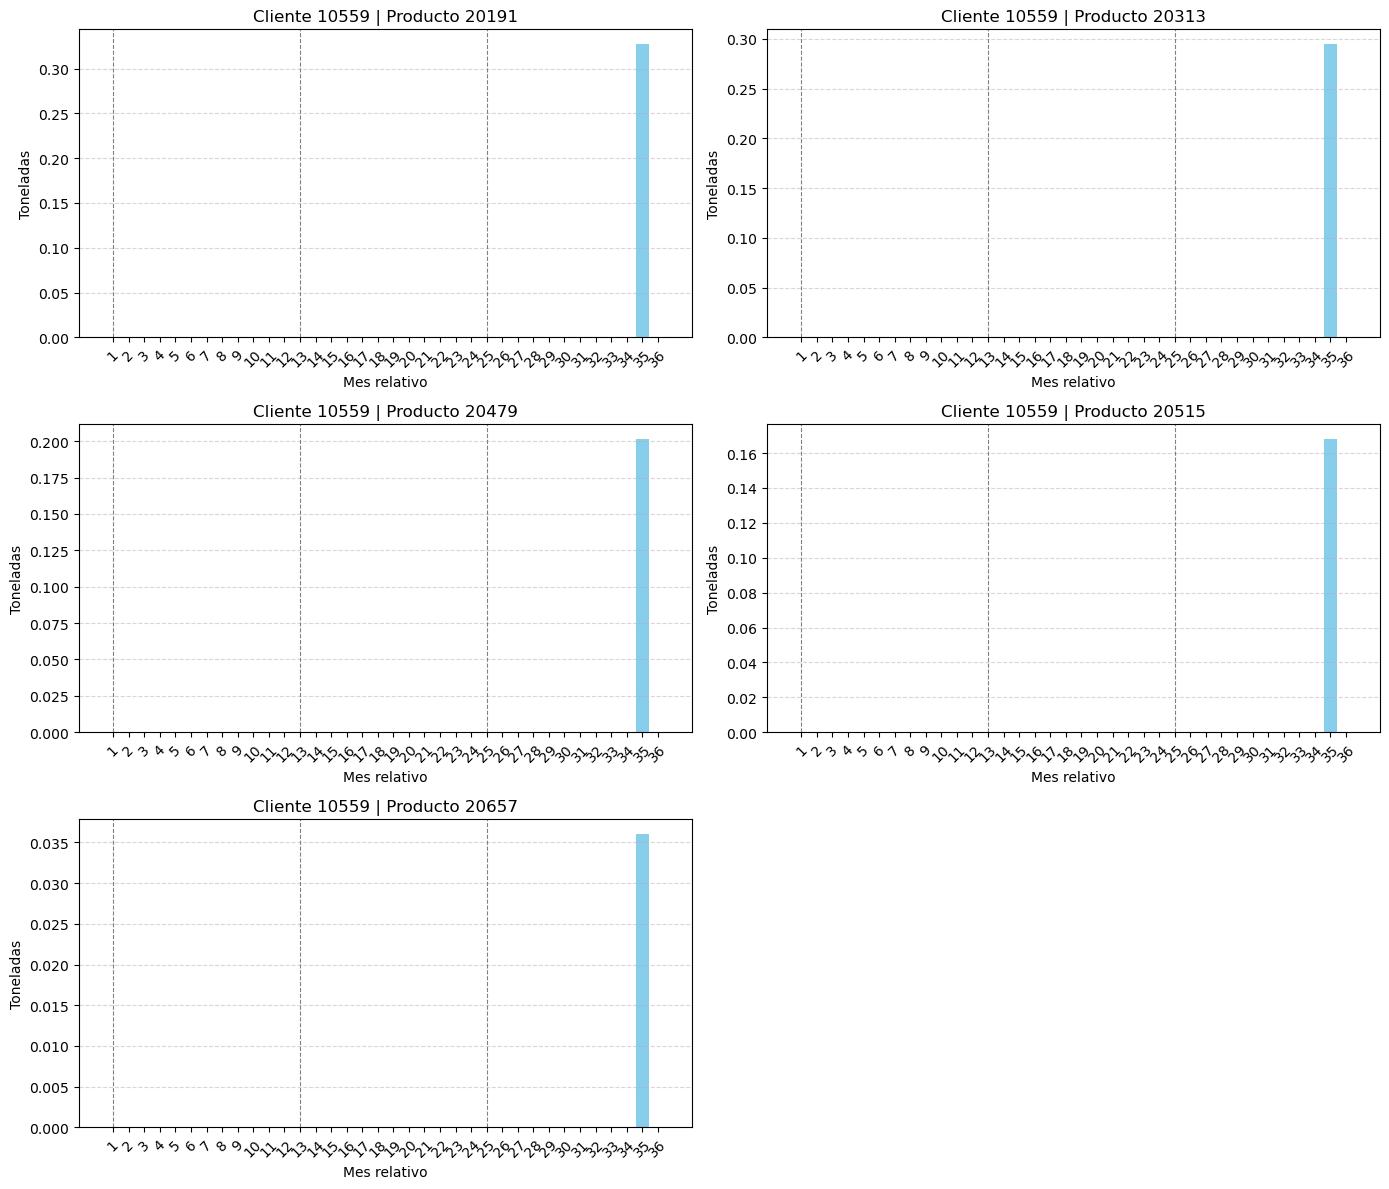

In [132]:
# Asegurar que 'periodo' esté en datetime
# df['periodo_dt'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')
graficar_cliente_y_productos(df, 10559,[20191, 20313, 20479, 20515, 20657] )

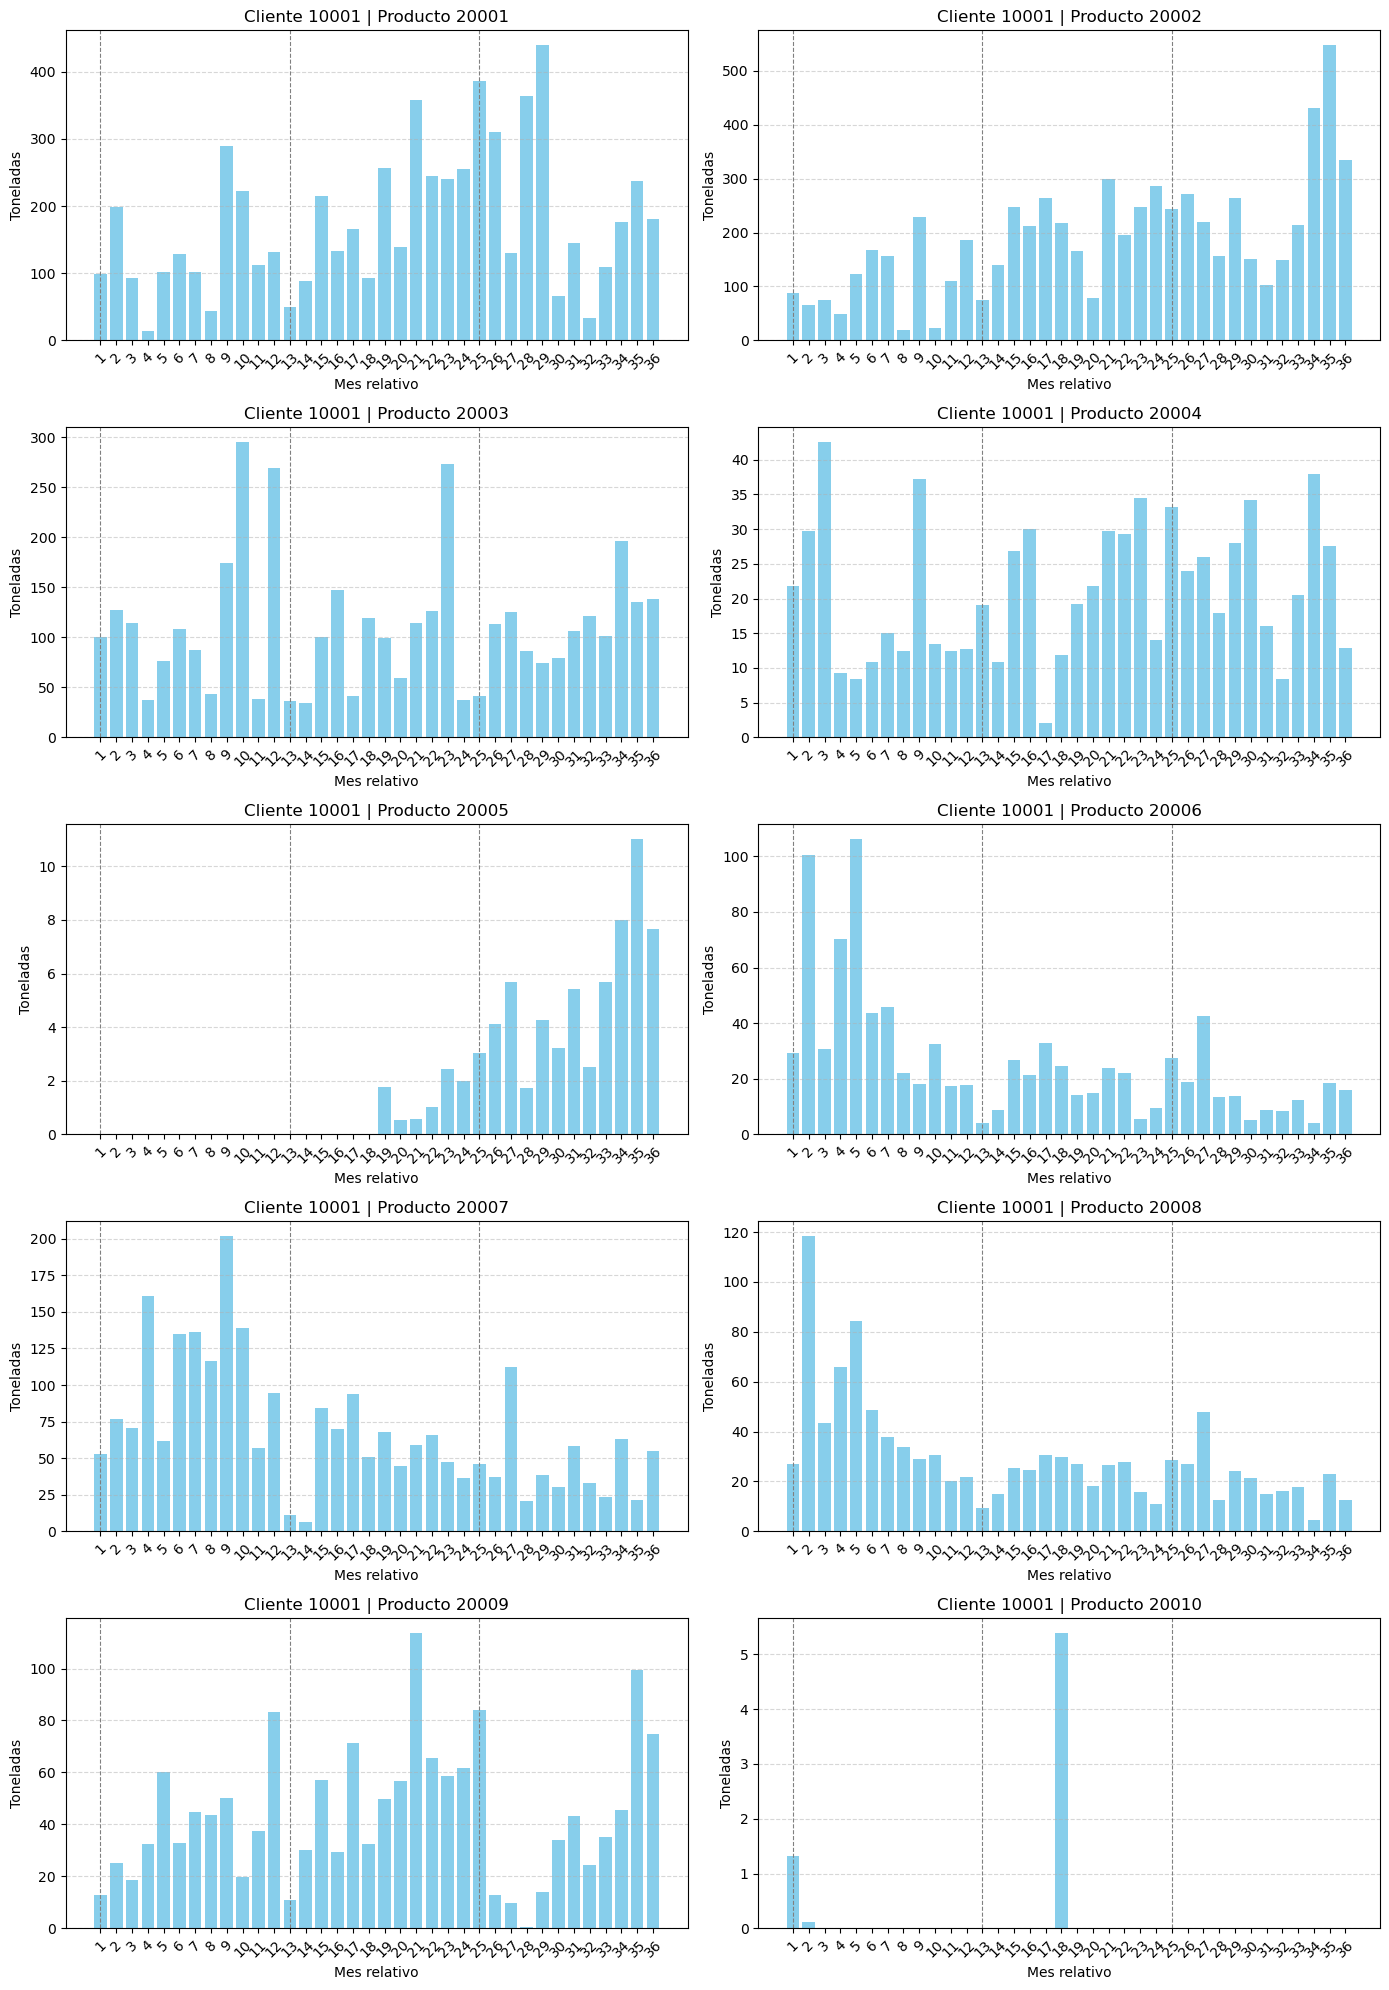

In [133]:
graficar_cliente_y_productos(df, cliente_id=10001, lista_productos=[20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010]) # cliente, producto

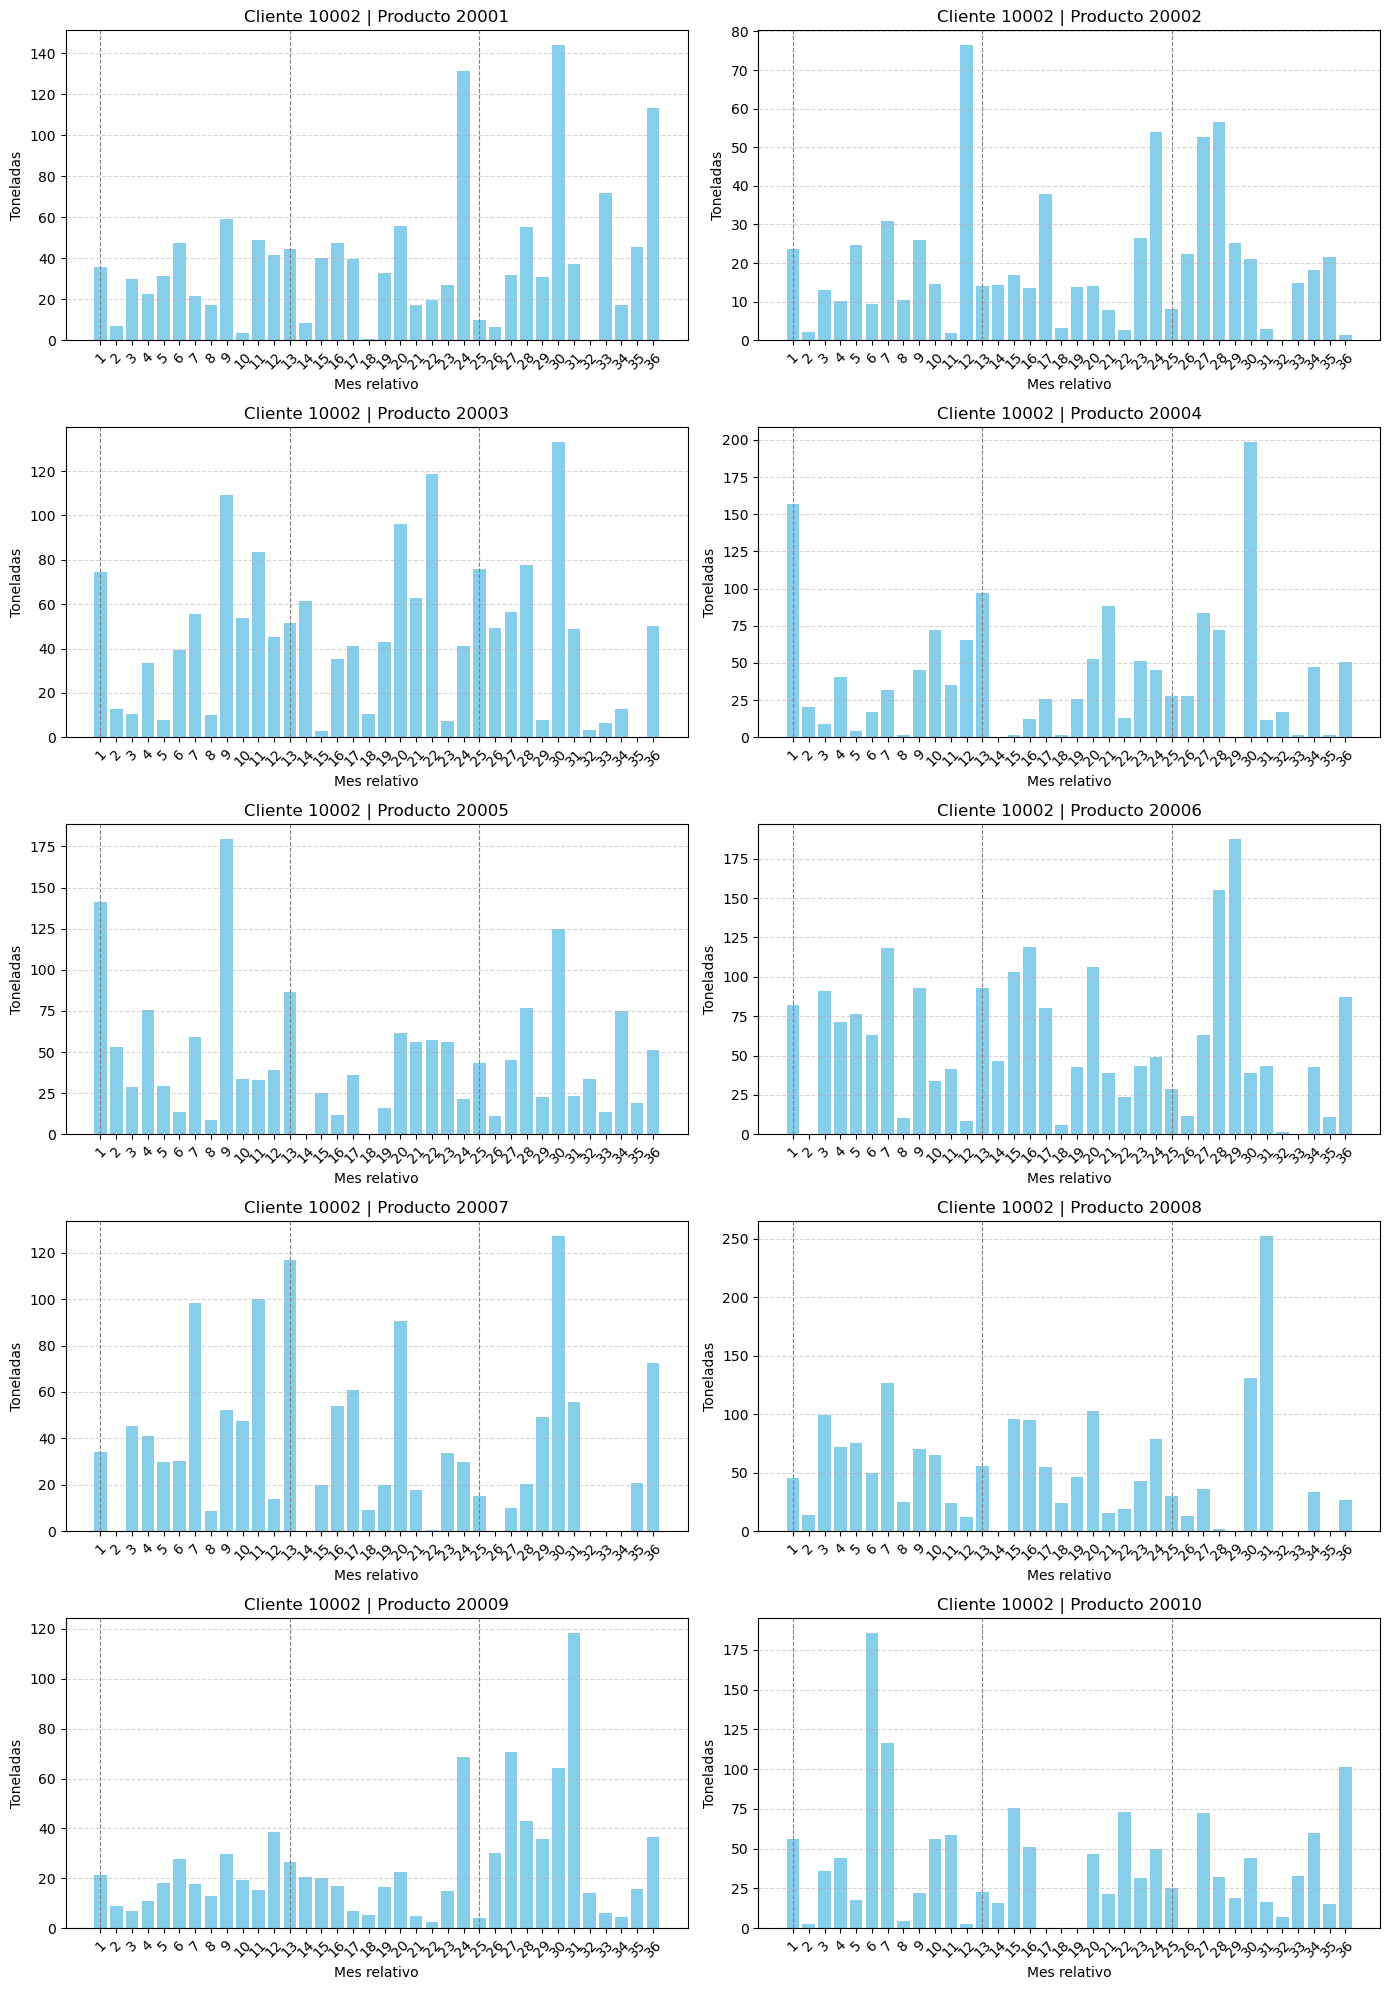

In [134]:
graficar_cliente_y_productos(df, cliente_id=10002, lista_productos=[20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010]) # cliente, producto

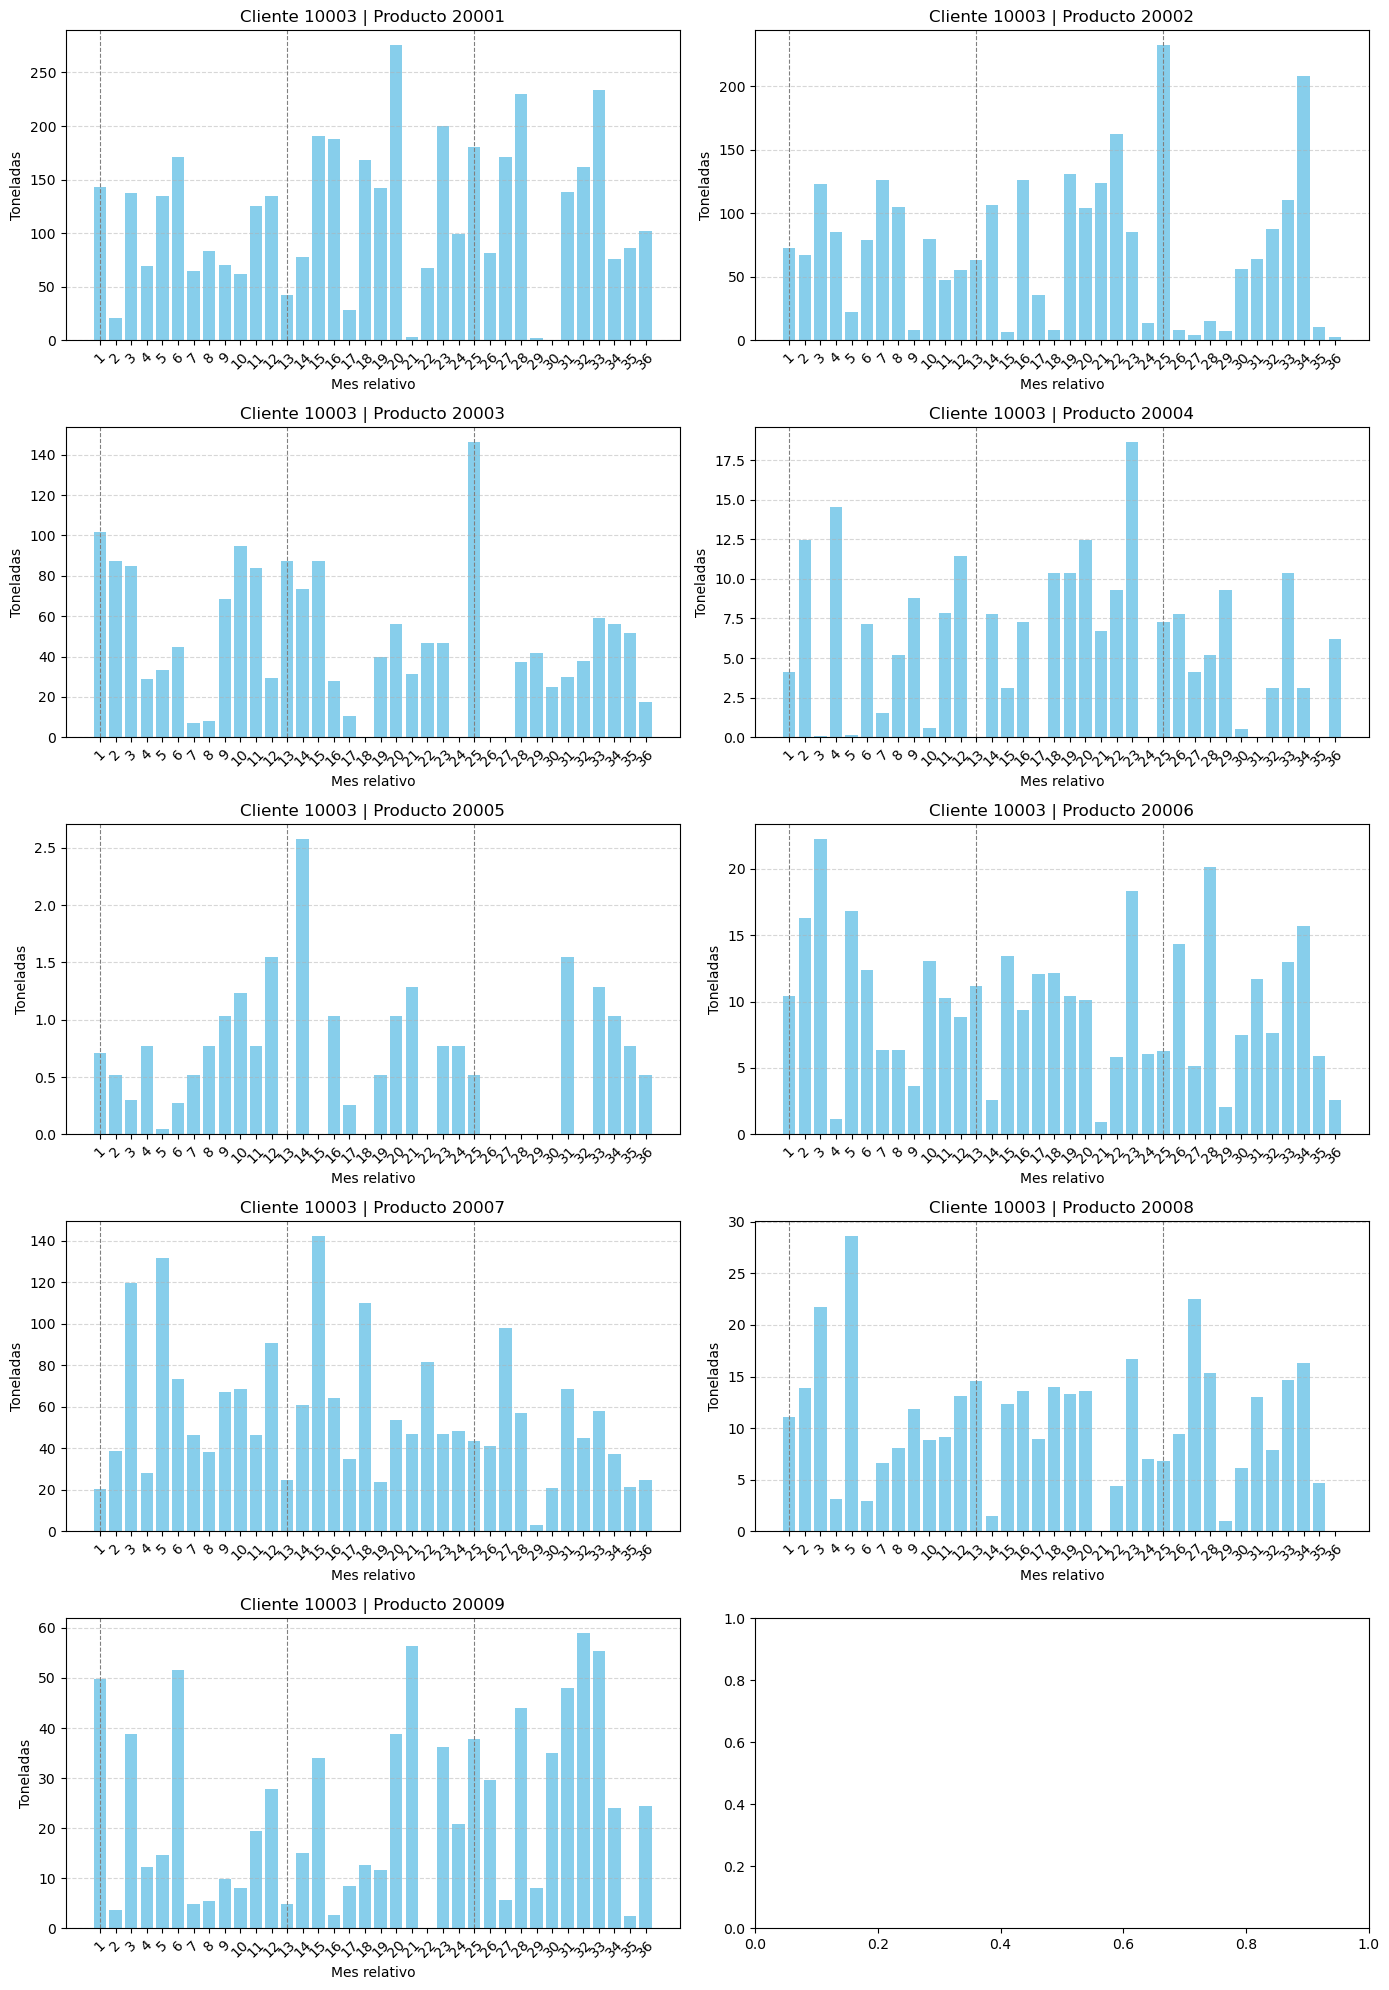

In [135]:
graficar_cliente_y_productos(df, cliente_id=10003, lista_productos=[20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010]) # cliente, producto

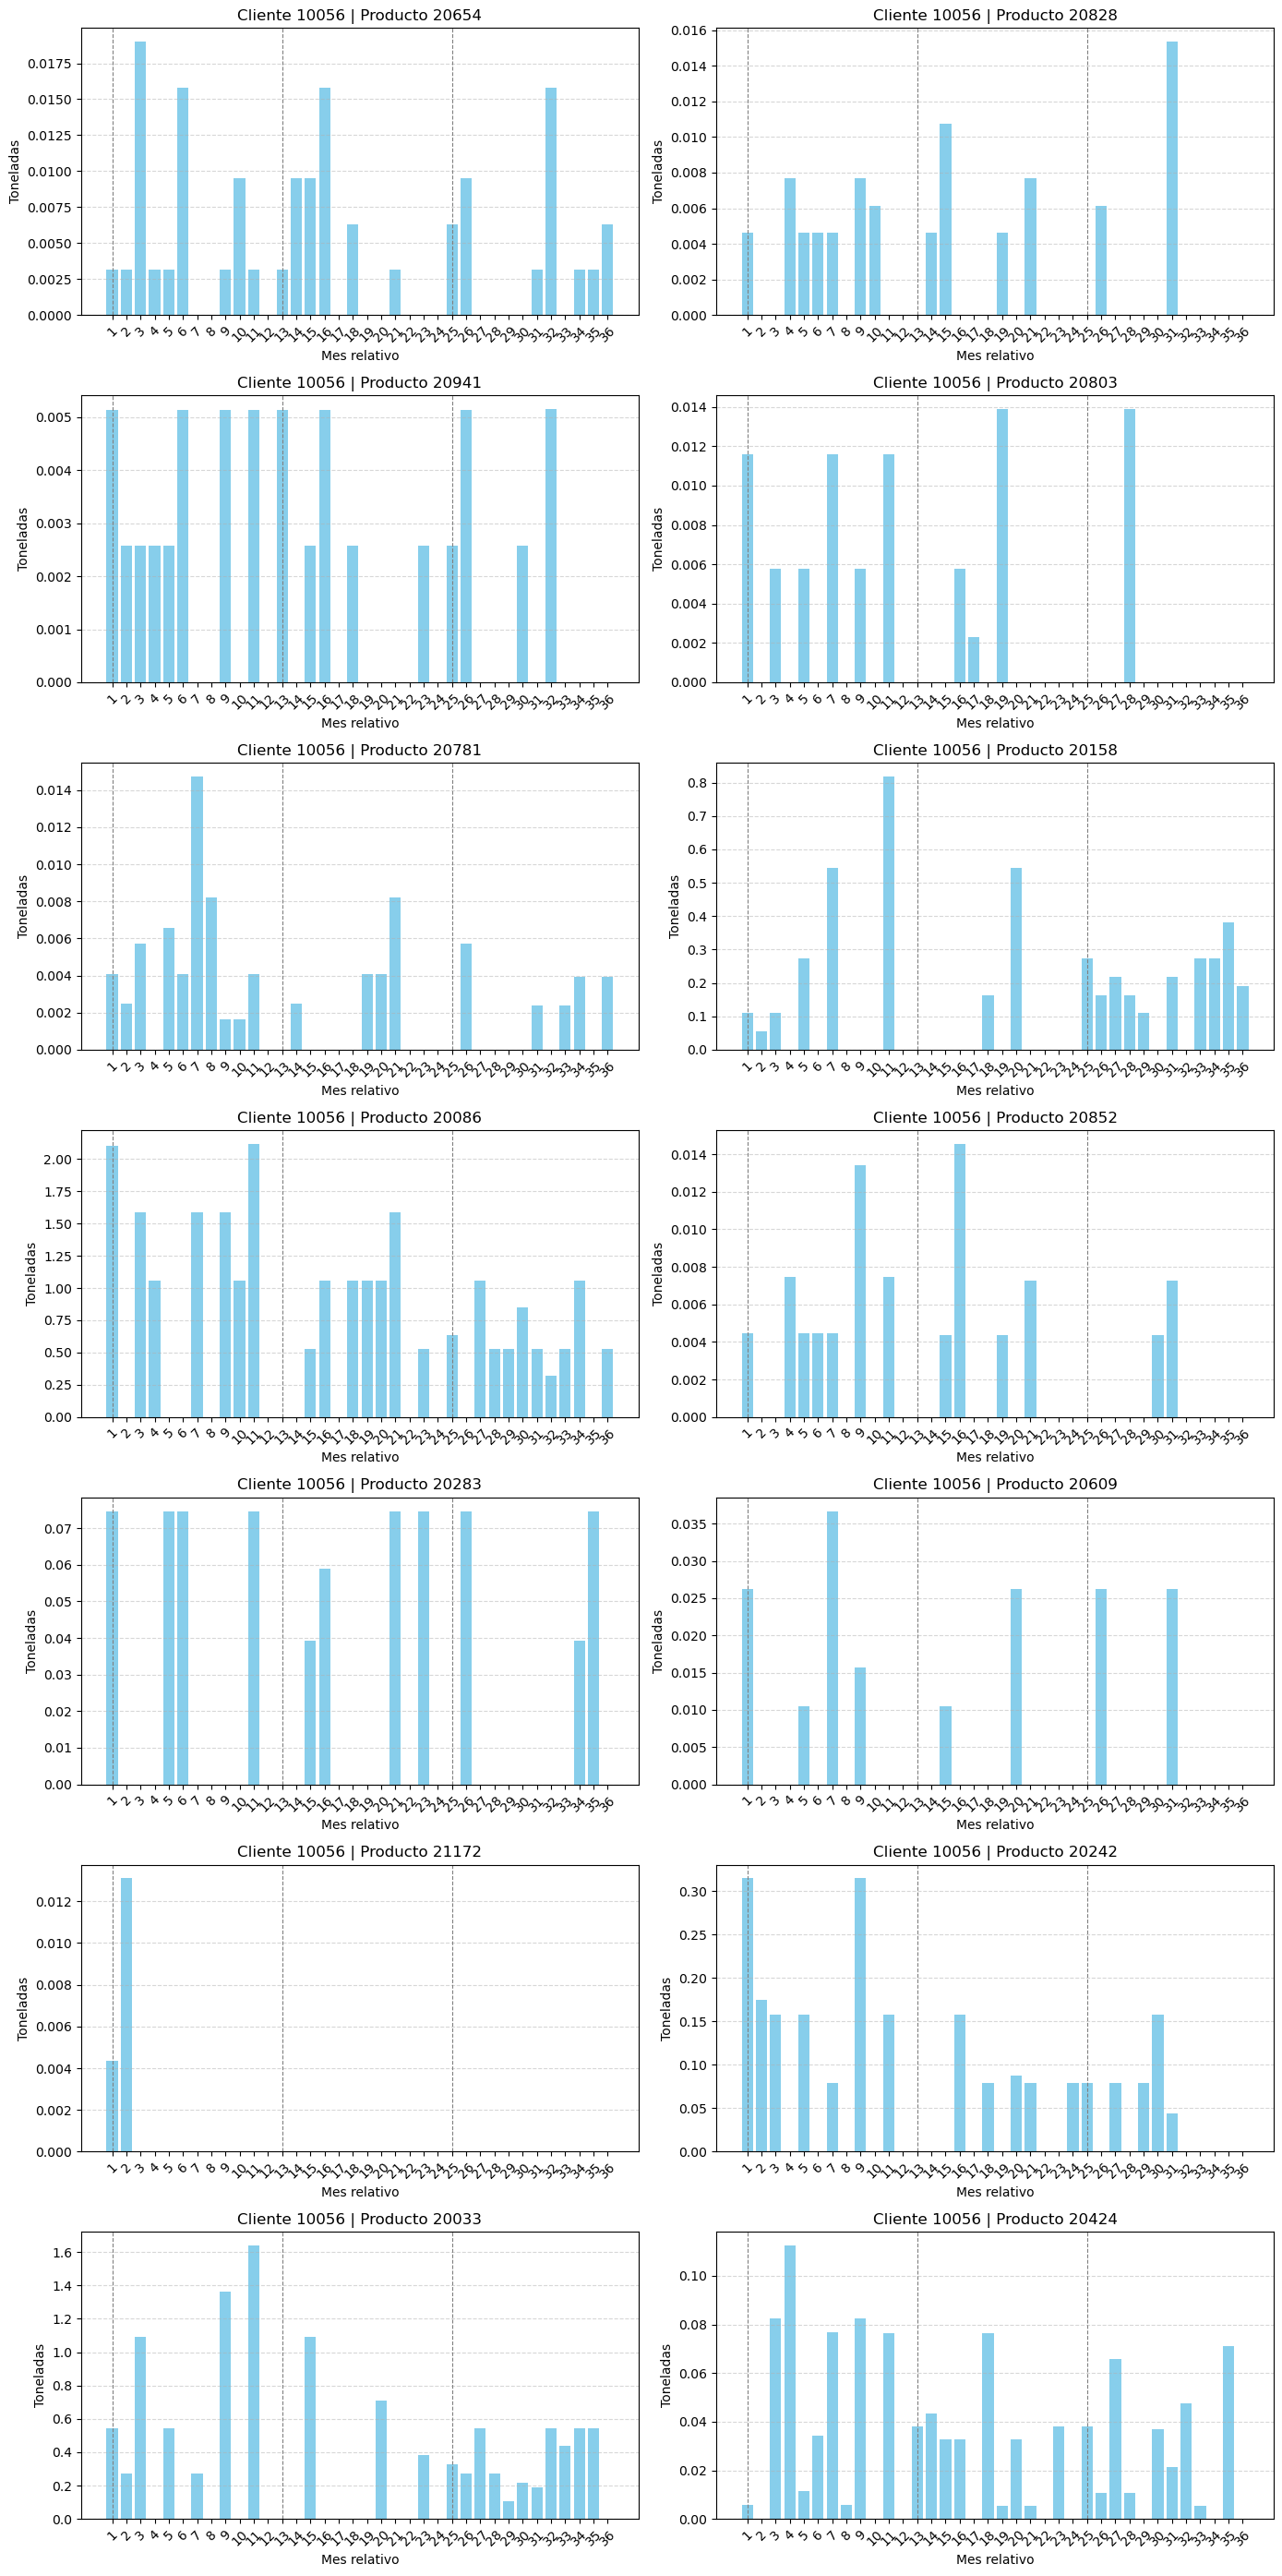

In [ ]:
graficar_cliente_y_productos(df, cliente_id=10056, lista_productos=[20654,
 20828,
 20941,
 20803,
 20781,
 20158,
 20086,
 20852,
 20283,
 20609,
 21172,
 20242,
 20033,
 20424]) # cliente, producto

In [73]:
# A nivel producto
ventas_producto = df.groupby('product_id')['tn'].sum().reset_index()

# A nivel cliente-producto
ventas_cliente_producto = df.groupby(['customer_id', 'product_id'])['tn'].sum().reset_index()


#### 1. ¿Cuántos productos tienen más de N clientes?

In [82]:
# Número de clientes por producto
clientes_por_producto = df.groupby('product_id')['customer_id'].nunique().reset_index(name='n_clientes')

# Filtrar productos con más de N clientes
N = 500
productos_mas_de_N_clientes = clientes_por_producto[clientes_por_producto['n_clientes'] > N]

print(f"📦 Productos con más de {N} clientes: {productos_mas_de_N_clientes.shape[0]}")


📦 Productos con más de 500 clientes: 20


#### 2. ¿Cuántos clientes compran más de M productos?

In [86]:
# Número de productos distintos por cliente
productos_por_cliente = df.groupby('customer_id')['product_id'].nunique().reset_index(name='n_productos')

# Filtrar clientes con más de M productos
M = 1000
clientes_mas_de_M_productos = productos_por_cliente[productos_por_cliente['n_productos'] > M]

print(f"👥 Clientes que compraron más de {M} productos: {clientes_mas_de_M_productos.shape[0]}")


👥 Clientes que compraron más de 1000 productos: 74


#### 3. ¿Qué proporción del total de toneladas se explica con los top 20 productos?

In [ ]:
# Total de toneladas por producto
tn_por_producto = df.groupby('product_id')['tn'].sum().reset_index().sort_values(by='tn', ascending=False)

# Calcular el total de toneladas y top 20
total_tn = tn_por_producto['tn'].sum()
top_20_tn = tn_por_producto.head(800)['tn'].sum()
proporcion_top_20 = top_20_tn / total_tn * 100

print(f"🔝 Los 800 productos más vendidos explican el {proporcion_top_20:.2f}% del total de toneladas.")


🔝 Los 50 productos más vendidos explican el 99.19% del total de toneladas.


#### 4. ¿Qué porcentaje de combinaciones <customer, product> tienen pocas compras?

💡 Criterio: “pocas compras” puede ser menos de 3 meses con ventas

In [108]:
# Contar cuántos meses con ventas tiene cada combinación customer-product
historial_cp = df[df['tn'] > 0].groupby(['customer_id', 'product_id'])['periodo'].nunique().reset_index(name='meses_con_venta')

# Total de combinaciones
total_combinaciones = historial_cp.shape[0]

# Filtrar las esporádicas (menos de 3 meses)
esporadicas = historial_cp[historial_cp['meses_con_venta'] == 2]
porcentaje_esporadicas = esporadicas.shape[0] / total_combinaciones * 100

print(f"📉 El {porcentaje_esporadicas:.2f}% de las combinaciones cliente-producto tienen menos de 3 meses de ventas.")


📉 El 12.25% de las combinaciones cliente-producto tienen menos de 3 meses de ventas.


In [140]:
df['product_id'].nunique()

1233

In [109]:
esporadicas

,customer_id,product_id,meses_con_venta
39,10001,20041,2
678,10001,20728,2
810,10001,20874,2
850,10001,20929,2
859,10001,20940,2
...,...,...,...
374400,10635,20353,2
374402,10635,20382,2
374413,10635,20672,2
374418,10635,20810,2


In [105]:
print(esporadicas.shape)
print(historial_cp['customer_id'].nunique())
print(df['customer_id'].nunique())

(71567, 3)
597
597


#### Cantidad de Compras de un Producto por Cliente por Periodo

In [150]:
# Filtrar el DataFrame por el producto deseado
df_producto = df[df['product_id'] == 20001]

# Agrupar por cliente y calcular cantidad de compras, toneladas totales y último período de compra
resumen_clientes = (
    df_producto
    .groupby('customer_id')
    .agg(
        cantidad_compras=('periodo', 'count'),
        toneladas_totales=('tn', 'sum'),
        ultimo_periodo=('periodo', 'max')  # 👉 último mes en que compró
    )
    .reset_index()
    .sort_values(by='toneladas_totales', ascending=False)
)

display(resumen_clientes)


,customer_id,cantidad_compras,toneladas_totales,ultimo_periodo
3,10004,36,7740.34113,201912
0,10001,36,6347.96490,201912
2,10003,35,4162.77308,201912
6,10007,36,3947.17979,201912
12,10013,36,3772.14516,201912
...,...,...,...,...
224,10239,1,0.03358,201708
419,10514,1,0.02240,201803
380,10440,1,0.02240,201907
438,10570,1,0.02239,201701


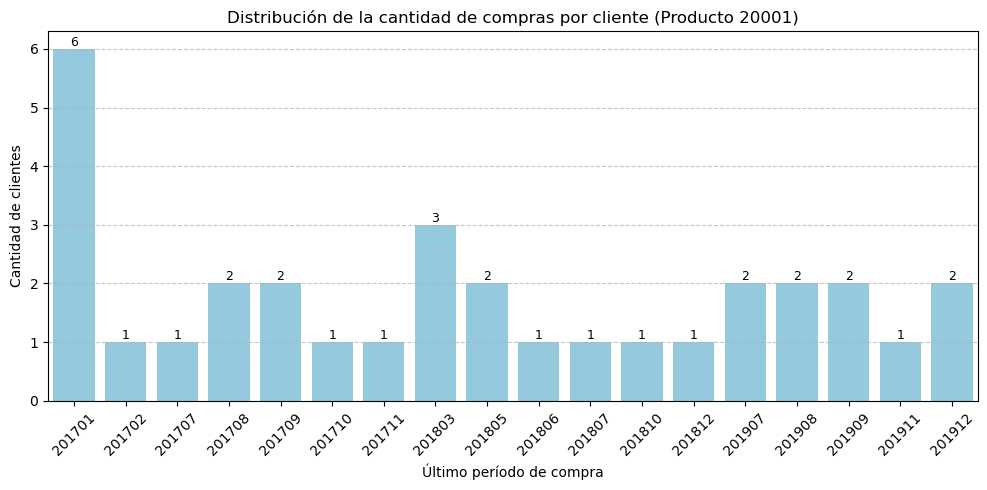

In [155]:
mask = resumen_clientes['cantidad_compras'] == 1
compra_1 = resumen_clientes[mask]

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=compra_1, x='ultimo_periodo', color='skyblue')

# Títulos y etiquetas
plt.title("Distribución de la cantidad de compras por cliente (Producto 20001)")
plt.xlabel("Último período de compra")
plt.ylabel("Cantidad de clientes")
plt.xticks(rotation=45)  # 👉 Rotar etiquetas del eje X
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar los números encima de cada barra
for p in ax.patches:
    altura = p.get_height()
    ax.annotate(f'{int(altura)}', (p.get_x() + p.get_width() / 2., altura),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


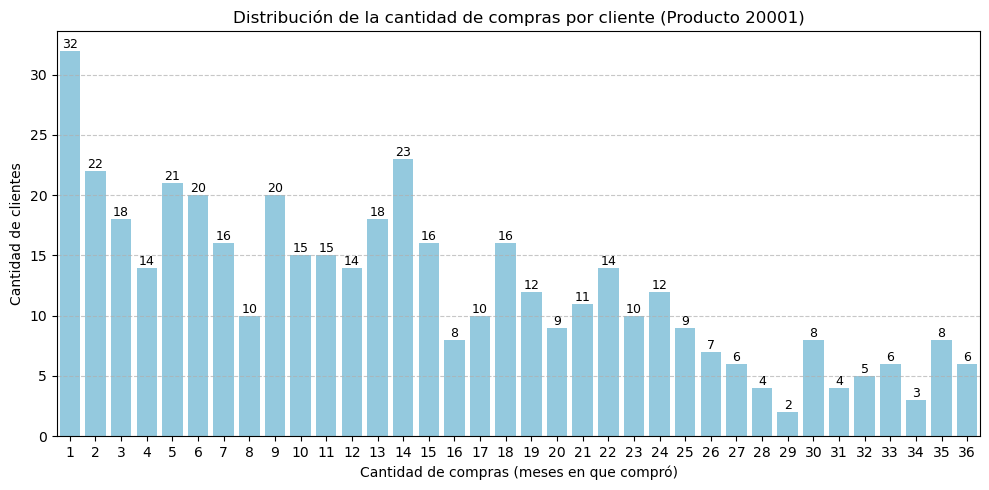

In [151]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=resumen_clientes, x='cantidad_compras', color='skyblue')

# Títulos y etiquetas
plt.title("Distribución de la cantidad de compras por cliente (Producto 20001)")
plt.xlabel("Cantidad de compras (meses en que compró)")
plt.ylabel("Cantidad de clientes")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar los números encima de cada barra
for p in ax.patches:
    altura = p.get_height()
    ax.annotate(f'{int(altura)}', (p.get_x() + p.get_width() / 2., altura),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
mask = (resumen_clientes['cantidad_compras'] == 36)
resumen_clientes[mask].shape

(6, 4)